In [1]:
import os
from utils import load_train_test
import time
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc

# specify the gpu device
# import os
# from Tools.utils import _make_dir, load_options
# options = load_options('options.json')
# os.environ["CUDA_DEVICE_ORDER"] = "OCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
SPLIT_MSG="***********"

In [4]:
DATA_DIR = './data/'
train_file = 'problem_id_train.csv'
test_file = 'problem_id_test.csv'
train_path= os.path.join(DATA_DIR, train_file)
test_path = os.path.join(DATA_DIR, test_file)

In [5]:
students_train, students_test, max_num_steps, num_problems = load_train_test(train_path, test_path)

Reading ./data/problem_id_train.csv
9990 lines was read
max_num_problems_answered: 1295
num_problems: 17751
The number of students is 3103
Finish reading data.
Reading ./data/problem_id_test.csv
2499 lines was read
max_num_problems_answered: 1169
num_problems: 17748
The number of students is 781
Finish reading data.


## Student Model

### Placeholder Explanation
X is the one-hot encoded input sequence of a student.
y is the one-hot encoded correct sequence of a student.

For example, the student i has a seq [1, 3, 1, 1, 2] with correct map [0, 1, 1, 1, 0]. The X_seq will be one hot encoded as:
$$
\left[
    \begin{array}{ccccc}
        0&1&0&0&0\\
        0&0&0&1&0\\
        0&1&0&0&0\\
        0&1&0&0&0\\
    \end{array}
\right]
$$

The X_corr map will be one hot encoded as:
$$
\left[
    \begin{array}{ccccc}
        0&0&0&0&0\\
        0&0&0&1&0\\
        0&1&0&0&0\\
        0&1&0&0&0\\
    \end{array}
\right]
$$

Then, it will be concatenated into $X^i$:
$$
\left[
    \begin{array}{ccccc|ccccc}
        0&1&0&0&0&0&0&0&0&0\\
        0&0&0&1&0&0&0&0&1&0\\
        0&1&0&0&0&0&1&0&0&0\\
        0&1&0&0&0&0&1&0&0&0\\
    \end{array}
\right]
$$

The last question '2' is not used in the $X^i$ because it is the last record that the student has and therefore used in $y$.
So, $y$ would be seq [3, 1, 1, 2] with corr map [1, 1, 1, 0]
$$
\left[
    \begin{array}{ccccc}
        0&0&0&1&0\\
        0&1&0&0&0\\
        0&1&0&0&0\\
        0&0&0&0&0\\
    \end{array}
\right]
$$


In [6]:
def seq_corr_to_onehot(seq, corr, num_steps, num_problems):
    seq_oh = tf.one_hot(seq, depth=num_problems)
    seq_oh_flat = tf.reshape(seq_oh, [-1, num_problems])
    
    # element-wise multiplication between Matrix and Vector
    # the i-th column of Matrixelement-wisedly multiply the i-th element in the Vector
    corr_flat = tf.reshape(corr, [-1])
    corr_mat = tf.multiply(tf.transpose(seq_oh_flat), tf.cast(corr_flat, dtype=tf.float32))
    corr_mat = tf.transpose(corr_mat)
    corr_mat = tf.reshape(corr_mat, shape=[-1, num_steps, num_problems])
    
    concat = tf.concat([seq_oh, corr_mat], axis=2)
    
    return seq_oh, corr_mat, concat

In [7]:
def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    length = tf.reduce_sum(used, 1)
    length = tf.cast(length, tf.int32)
    return length

In [8]:
# network configuration
batch_size = 16
max_num_steps = max_num_steps - 1
num_problems = num_problems
keep_prob = tf.placeholder(tf.float32)

inputs_seq = tf.placeholder(tf.int32, [None, max_num_steps])
inputs_corr = tf.placeholder(tf.int32, [None, max_num_steps])
X_seq, X_corr, X = seq_corr_to_onehot(inputs_seq, inputs_corr, max_num_steps, num_problems)

targets_seq = tf.placeholder(tf.int32, [None, max_num_steps])
targets_corr = tf.placeholder(tf.int32, [None, max_num_steps])
y_seq, y_corr, _ = seq_corr_to_onehot(targets_seq, targets_corr, max_num_steps, num_problems)

In [9]:
X.shape

TensorShape([Dimension(None), Dimension(1294), Dimension(35502)])

In [7]:
# build up the network
hl1_size = 200
sequence_length = length(X_seq)

with tf.variable_scope('hidden_layer_1'):
    hl1_cell = tf.contrib.rnn.LSTMCell(num_units=hl1_size)
    hl1_cell = tf.contrib.rnn.DropoutWrapper(hl1_cell, output_keep_prob=keep_prob)
    hl1_output, hl1_state = tf.nn.dynamic_rnn(
        hl1_cell,
        X,
        dtype=tf.float32,
#         sequence_length=sequence_length
    )

last_layer_size = hl1_size
last_layer_output, last_layer_state = hl1_output, hl1_state

In [8]:
# this code block calculate the loss using tf.gather_nd
W_yh = tf.Variable(tf.random_normal([last_layer_size, num_problems]), name="W_yh")
b_yh = tf.Variable(tf.constant(0.1, shape=[num_problems,]), name="b_yh")

last_layer_output_flat = tf.reshape(last_layer_output, [-1, last_layer_size])
logits_flat = tf.matmul(last_layer_output_flat, W_yh) + b_yh
preds_flat = tf.sigmoid(logits_flat)
y_seq_flat = tf.cast(tf.reshape(y_seq, [-1, num_problems]), dtype=tf.float32)
y_corr_flat = tf.cast(tf.reshape(y_corr, [-1, num_problems]), dtype=tf.float32)

# get the indices where they are not equal to 0
# the indices implies that a student has answered the question in the time step
# and thereby exclude those time step that the student hasn't answered.
target_indices = tf.where(tf.not_equal(y_seq_flat, 0))
target_logits = tf.gather_nd(logits_flat, target_indices)
target_preds = tf.gather_nd(preds_flat, target_indices)
target_labels = tf.gather_nd(y_corr_flat, target_indices)

loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=target_logits, 
                                               labels=target_labels)
total_loss = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

In [29]:
def optimize(sess, print_loss=False):    
    students = students_train
    
    best_test_auc = 0
    best_epoch_idx = 0
    for epoch_idx in range(num_epochs):
        y_pred = []
        y_true = []
        
        num_students = 10
        num_students = len(students) 

        loss_train = 0
        iteration = 1
        
        for batch_idx in range(0, num_students, batch_size):
            start_idx = batch_idx
            end_idx = min(num_students, batch_idx+batch_size)
            
            new_batch_size = end_idx - start_idx
            
            inputs_seq_batch = np.array([tup[1][:-1] for tup in students[start_idx:end_idx]], dtype=np.int32)
            inputs_corr_batch = np.array([tup[2][:-1] for tup in students[start_idx:end_idx]], dtype=np.int32)
            
            y_seq_batch = np.array([tup[1][1:] for tup in students[start_idx:end_idx]], dtype=np.int32)
            y_corr_batch = np.array([tup[2][1:] for tup in students[start_idx:end_idx]], dtype=np.int32)

            _optimizer, _target_preds, _target_labels, _total_loss = sess.run(
                    [optimizer, target_preds, target_labels, total_loss],
                    feed_dict={
                    inputs_seq: inputs_seq_batch,
                    inputs_corr: inputs_corr_batch,
                    targets_seq: y_seq_batch,
                    targets_corr: y_corr_batch,
                    keep_prob: 0.5,
                })
            
            y_pred += [p for p in _target_preds]
            y_true += [t for t in _target_labels]
            loss_train = (iteration-1)/(iteration) * loss_train + _total_loss/iteration
            iteration+=1
        
        # Print training information        
        fpr, tpr, thres = roc_curve(y_true, y_pred, pos_label=1)
        auc_train = auc(fpr, tpr)
        print('Epoch {0:>4}, Train AUC: {1:.5}, Train Loss: {2:.5}'.format(epoch_idx+1, auc_train, loss_train))
        
        # evaluate on the test set
        auc_test, loss_test = evaluate(sess, is_train=False)
        test_msg = "Epoch {0:>4}, Test AUC: {1:.5}, Test Loss: {2:.5}".format(epoch_idx+1, auc_test, loss_test)
        if auc_test > best_test_auc:
            test_msg += "*"
            best_epoch_idx = epoch_idx
            best_test_auc = auc_test
            saver.save(sess=sess, save_path=save_path)
        print(test_msg)
        print(SPLIT_MSG)        
        # quit the training if there is no improve in AUC for 20 epochs.
        if epoch_idx - best_epoch_idx >= 20:
            print("No improvement shown in 20 epochs. Quit Training.")
            break
    print("The best testing result occured at: {0}-th epoch, with testing AUC: {1:.5}".format(best_epoch_idx, best_test_auc))
        
        
        

def evaluate(sess, is_train=False):    
    if is_train:
        students = students_train
    else:
        students = students_test
    
    y_pred = []
    y_true = []
    iteration = 1
    _loss = 0
    
    num_students = 10
    num_students = len(students)
    
    for batch_idx in range(0, num_students, batch_size):
        start_idx = batch_idx
        end_idx = min(num_students, batch_idx+batch_size)

        new_batch_size = end_idx - start_idx

        inputs_seq_batch = np.array([tup[1][:-1] for tup in students[start_idx:end_idx]], dtype=np.int32)
        inputs_corr_batch = np.array([tup[2][:-1] for tup in students[start_idx:end_idx]], dtype=np.int32)

        y_seq_batch = np.array([tup[1][1:] for tup in students[start_idx:end_idx]], dtype=np.int32)
        y_corr_batch = np.array([tup[2][1:] for tup in students[start_idx:end_idx]], dtype=np.int32)

        _target_preds, _target_labels, _total_loss = sess.run(
                [target_preds, target_labels, total_loss],
                feed_dict={
                inputs_seq: inputs_seq_batch,
                inputs_corr: inputs_corr_batch,
                targets_seq: y_seq_batch,
                targets_corr: y_corr_batch,
                keep_prob: 1,
            })

        y_pred += [p for p in _target_preds]
        y_true += [t for t in _target_labels]
        _loss = (iteration-1)/(iteration) * _loss + _total_loss/iteration
        iteration+=1

    fpr, tpr, thres = roc_curve(y_true, y_pred, pos_label=1)
    auc_score = auc(fpr, tpr)
    return (auc_score, _loss)

def get_student_output_layer(sess, student):
    num_steps = len(student[1]) - 1
    shape = (1, num_steps)
    _inputs_seq = np.array(student[1][:-1]).reshape(shape)
    _inputs_corr = np.array(student[2][:-1]).reshape(shape)
    
    _y_seq = np.array(student[1][1:]).reshape(shape)
    _y_corr = np.array(student[2][1:]).reshape(shape)
    
    _preds_flat = sess.run(
        preds_flat,
        feed_dict={
            inputs_seq: _inputs_seq,
            inputs_corr: _inputs_corr,
            targets_seq: _y_seq,
            targets_corr: _y_corr,
            keep_prob: 1,
        }
    )    
    return _preds_flat

def get_student_hidden_layer(sess, student, layer_num=1):
    _inputs_seq = np.array(tup[1][:-1])
    _inputs_corr = np.array(tup[2][:-1])
    
    _y_seq = np.array(tup[1][1:])
    _y_corr = np.array(tup[2][1:])
    
    feed_dict={
            inputs_seq: _inputs_seq,
            inputs_corr: _inputs_corr,
            targets_seq: _y_seq,
            targets_corr: _y_corr,
            keep_prob: 1,
        }
    
    result = None
    if layer_num == 1:
        result = sess.run(
            [hl1_output],
            feed_dict=feed_dict,
        )
    elif layer_num == 2:
        result = sess.run(
            [hl2_output],
            feed_dict=feed_dict,
        )
    else:
        print("layer is not available")
        return None
    return result
    

In [10]:
### Define the tf saver
saver = tf.train.Saver()
save_dir = 'checkpoints/original_temp_1hl_200/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'model')

In [ ]:
WITH_CONFIG = True
num_epochs = 1000

### Start Training
start_time = time.time()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    try:
        saver.restore(sess=sess, save_path=save_path)
        print("Pre-trained model found, loading the previous variables")
    except:
        print("Pre-trained model not found, train from scratch now.")
    optimize(sess)
    
end_time = time.time()

print("program run for: {0}s".format(end_time-start_time))

In [30]:
sess = tf.Session()
print("Loading the saved variable to the current session.")
saver.restore(sess=sess, save_path=save_path)

auc_test, loss_test = evaluate(sess, is_train=False)
print ("auc_test: {0:.5}, loss_test: {0:.5}".format(auc_test, loss_test))

Loading the saved variable to the current session.
INFO:tensorflow:Restoring parameters from checkpoints/original/model
auc_test: 0.80057, loss_test: 0.80057


In [27]:
tf.trainable_variables()

[<tf.Variable 'hidden_layer_1/rnn/lstm_cell/kernel:0' shape=(448, 800) dtype=float32_ref>,
 <tf.Variable 'hidden_layer_1/rnn/lstm_cell/bias:0' shape=(800,) dtype=float32_ref>,
 <tf.Variable 'W_yh:0' shape=(200, 124) dtype=float32_ref>,
 <tf.Variable 'b_yh:0' shape=(124,) dtype=float32_ref>]

In [ ]:
import matplotlib.pyplot as plt
import math
%matplotlib inline
#http://bokeh.pydata.org/en/0.10.0/docs/gallery/cat_heatmap_chart.html

def plot_heatmap(data, x_labels, y_labels, second_x_labels=None):
#     plt.figure(figsize=(40,100))

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
    
    # Format
    fig = plt.gcf()
    
    # turn off the frame
    ax.set_frame_on(False)
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(len(x_labels)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(y_labels)) + 0.5, minor=False)
    
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    # set the label
    ax.set_xticklabels(x_labels, minor=False)
    ax.set_yticklabels(y_labels, minor=False)
    ax.set_xlabel("the skill id answered at the time step")
    ax.set_ylabel("the skill id of the output layer")

    fig.set_size_inches(15, 5)
    
    # second axis label
    if second_x_labels != None:
        ax2 = ax.twiny()
        ax2.set_xticks(np.arange(len(second_x_labels)) + 0.5, minor=False)
        ax2.set_xticklabels(second_x_labels)
        ax2.set_xlabel("Correct Label")

    # Turn off all the ticks
    ax = plt.gca()
    plt.show()

In [32]:
targets = []
for i in range(len(students_test)):
    student = students_test[i]
    num_question_answered = student[0]
    question_ids_answered = np.sort(np.array([int(qid) for qid in set(student[1]) if qid != -1]))
    num_distict_question = len(question_ids_answered)
    
    if 50 >= num_question_answered >= 20 and 10 >= num_distict_question >= 5:
        targets.append(i)
    
print(targets)

[2, 13, 22, 42, 43, 49, 55, 83, 89, 97, 99, 104, 111, 118, 126, 132, 137, 154, 169, 171, 174, 176, 179, 183, 193, 227, 235, 239, 261, 295, 308, 309, 321, 328, 348, 350, 352, 363, 364, 366, 375, 376, 385, 387, 388, 399, 401, 402, 406, 421, 422, 433, 477, 481, 486, 487, 493, 495, 498, 532, 534, 537, 540, 551, 575, 582, 607, 612, 613, 633, 634, 646, 647, 657, 660, 681, 686, 687, 691, 697, 707, 715, 726, 727, 740, 741, 754, 757, 759, 773, 774, 777]


In [21]:
sid = targets[0]
student = students_test[sid]
num_question_answered = student[0]
question_ids_answered = np.sort(np.array([int(qid) for qid in set(student[1]) if qid != -1]))
output_layer = get_student_output_layer(sess, student)
output_layer = output_layer[:num_question_answered, question_ids_answered]
output_layer = np.transpose(output_layer)

question_seq = student[1][:num_question_answered]
correct_seq = student[2][:num_question_answered]

print(num_question_answered),
print(question_seq)
print(correct_seq)

20
['76', '76', '76', '76', '76', '49', '80', '81', '55', '76', '49', '80', '81', '55', '76', '49', '80', '81', '55', '76']
['1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '0']


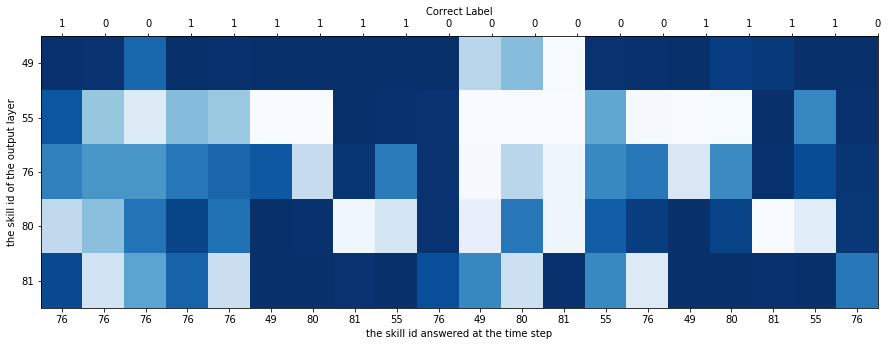

In [22]:
plot_heatmap(output_layer, student[1][:num_question_answered], question_ids_answered, student[2][:num_question_answered])

In [ ]:
sess.close()